# Annotation

Consider a binary classification problem. We will fit a predictor and use it to assign a weight score to each node in each instance; this operation is referred to as "annotation". For illustration purposes we will display a few annotated graphs. We will see that building a predictor on the annotated instances can increase the predictive performance.

In [20]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

load data and convert it to graphs

In [21]:
pos = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_pos.gspan'
neg = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_neg.gspan'

from eden.converter.graph.gspan import gspan_to_eden
iterable_pos = gspan_to_eden( pos )
iterable_neg = gspan_to_eden( neg )

#split train/test
train_test_split=0.7
from eden.util import random_bipartition_iter
iterable_pos_train, iterable_pos_test = random_bipartition_iter(iterable_pos, relative_size=train_test_split)
iterable_neg_train, iterable_neg_test = random_bipartition_iter(iterable_neg, relative_size=train_test_split)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi_pos.gspan HTTP/1.1" 200 714032
Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi_neg.gspan HTTP/1.1" 200 538391


setup the vectorizer

In [22]:
complexity = 1
n_iter_search = 1

In [23]:
from eden.graph import Vectorizer
vectorizer = Vectorizer( complexity=complexity )

In [24]:
%%time
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)
iterable_neg_train,iterable_neg_train_=tee(iterable_neg_train)
iterable_pos_test,iterable_pos_test_=tee(iterable_pos_test)
iterable_neg_test,iterable_neg_test_=tee(iterable_neg_test)

from eden.util import fit,estimate
estimator = fit(iterable_pos_train_, iterable_neg_train_,
                vectorizer, n_iter_search=n_iter_search)
estimate(iterable_pos_test_, iterable_neg_test_, estimator, vectorizer)

Positive data: Instances: 1680 ; Features: 1048577 with an avg of 23 features per instance
Negative data: Instances: 1355 ; Features: 1048577 with an avg of 22 features per instance
Elapsed time: 8.6 secs
Test set
Instances: 1300 ; Features: 1048577 with an avg of 23 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.73      0.81      0.77       580
          1       0.83      0.76      0.80       720

avg / total       0.79      0.79      0.79      1300

APR: 0.876
ROC: 0.866
Cross-validated estimate
            accuracy: 0.784 +- 0.015
           precision: 0.805 +- 0.015
              recall: 0.804 +- 0.017
                  f1: 0.805 +- 0.014
   average_precision: 0.862 +- 0.015
             roc_auc: 0.850 +- 0.016
CPU times: user 7.67 s, sys: 1.5 s, total: 9.17 s
Wall time: 14.8 s


annotate instances and list all resulting graphs

display one graph as an example. Color the vertices using the annotated 'importance' attribute.

In [25]:
help(vectorizer.annotate)

Help on method annotate in module eden.graph:

annotate(self, graphs, estimator=None, reweight=1.0, relabel=False) method of eden.graph.Vectorizer instance
    Given a list of networkx graphs, and a fitted estimator, return a list of networkx
    graphs where each vertex has an additional attribute with key 'importance'.
    The importance value of a vertex corresponds to the part of the score that is imputable
    to the neighborhood of radius r+d of the vertex.
    It can overwrite the label attribute with the sparse vector corresponding to the
    vertex induced features.
    
    Parameters
    ----------
    estimator : scikit-learn estimator
        Scikit-learn predictor trained on data sampled from the same distribution.
        If None the vertex weigths are set by default 1.
    
    reweight : float (default 1.0)
        The  coefficient used to weight the linear combination of the current weight and
        the absolute value of the score computed by the estimator.
        

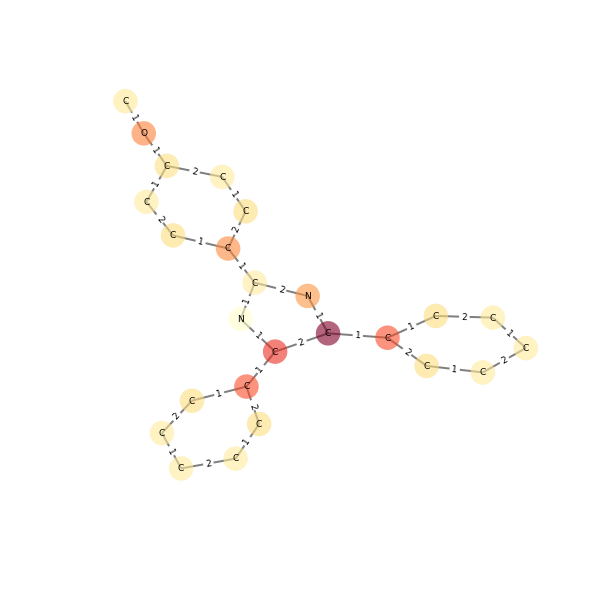

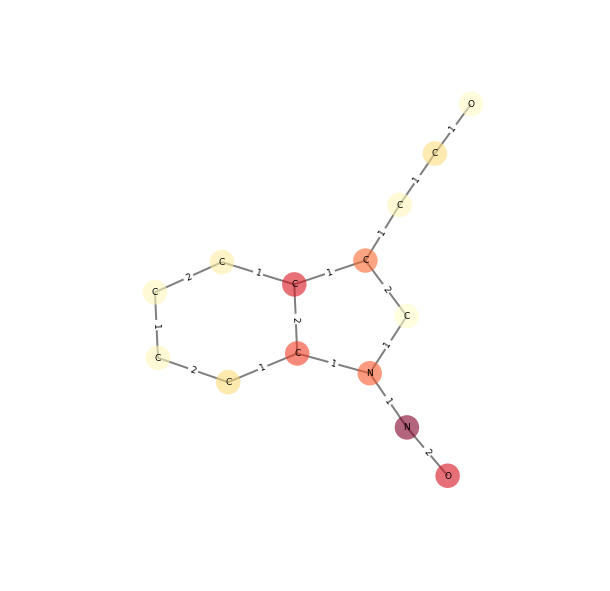

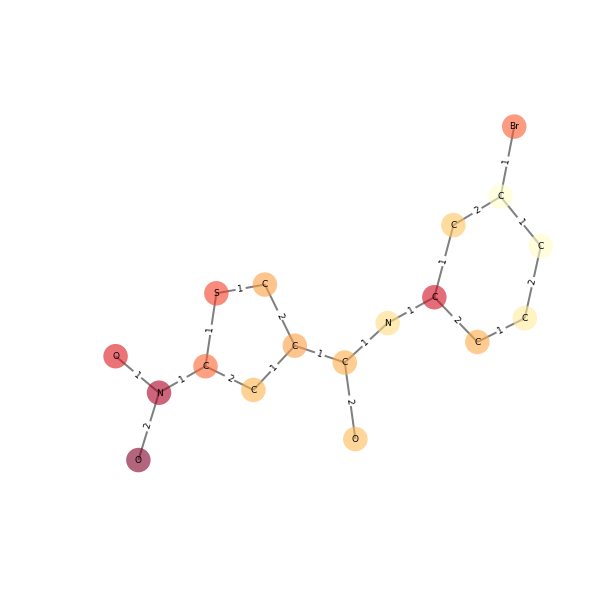

In [26]:
%matplotlib inline
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

import itertools 
graphs = itertools.islice( graphs, 3 )

from eden.util.display import draw_graph
for graph in graphs: draw_graph( graph, vertex_color='importance', size=10 )

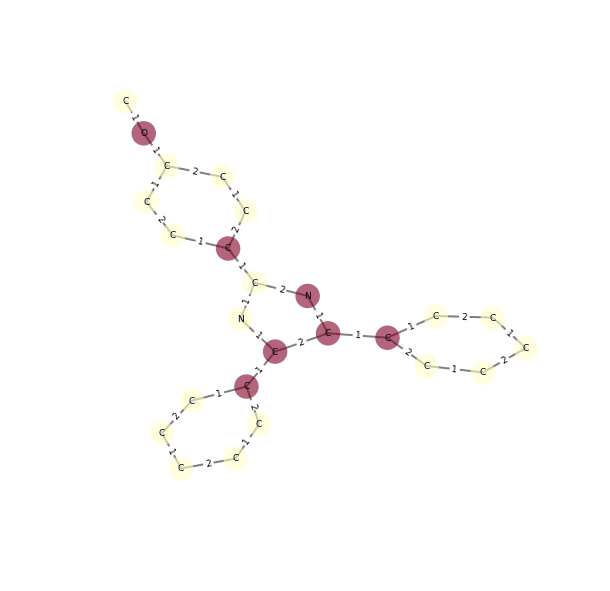

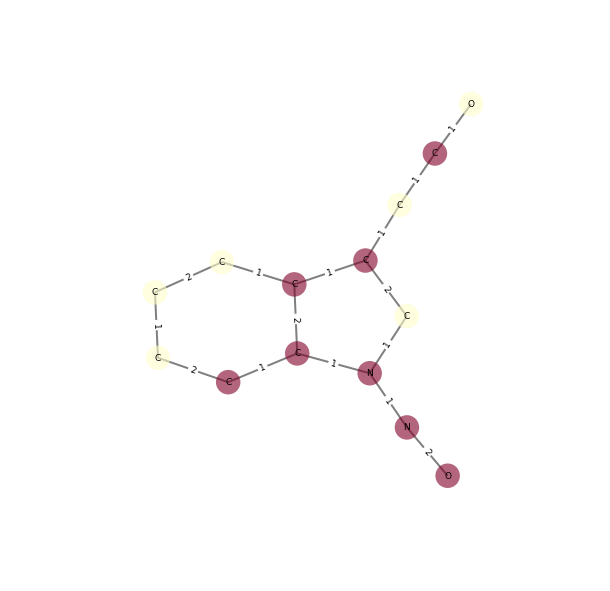

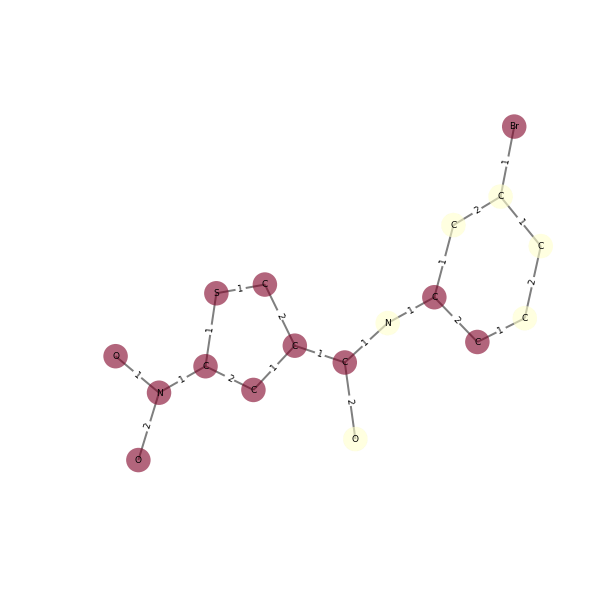

In [27]:
%matplotlib inline
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

from eden.modifier.graph.vertex_attributes import colorize_binary
graphs = colorize_binary(graph_list = graphs, output_attribute = 'color_value', input_attribute='importance', level=0)

import itertools 
graphs = itertools.islice( graphs, 3 )

from eden.util.display import draw_graph
for graph in graphs: draw_graph( graph, vertex_color='color_value', size=10 )

Create a data matrix this time using the annotated graphs. Note that now graphs are weighted. 

Evaluate the predictive performance on the weighted graphs.

In [28]:
%%time
a_estimator=estimator
num_iterations = 30
reweight = 0.5
for i in range(num_iterations):
    print 'Iteration %d/%d'%(i+1,num_iterations)
    
    from itertools import tee
    iterable_pos_train_=vectorizer.annotate( iterable_pos_train, estimator=a_estimator, reweight=reweight )
    iterable_neg_train_=vectorizer.annotate( iterable_neg_train, estimator=a_estimator, reweight=reweight )
    iterable_pos_test_=vectorizer.annotate( iterable_pos_test, estimator=a_estimator, reweight=reweight )
    iterable_neg_test_=vectorizer.annotate( iterable_neg_test, estimator=a_estimator, reweight=reweight )
    
    iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train_)
    iterable_neg_train,iterable_neg_train_=tee(iterable_neg_train_)
    iterable_pos_test,iterable_pos_test_=tee(iterable_pos_test_)
    iterable_neg_test,iterable_neg_test_=tee(iterable_neg_test_)

    from eden.util import fit,estimate
    a_estimator = fit(iterable_pos_train_, iterable_neg_train_, 
                      vectorizer, n_iter_search=n_iter_search)
    estimate(iterable_pos_test_, iterable_neg_test_, a_estimator, vectorizer)

Iteration 1/30
Positive data: Instances: 1680 ; Features: 1048577 with an avg of 23 features per instance
Negative data: Instances: 1355 ; Features: 1048577 with an avg of 22 features per instance
Elapsed time: 44.0 secs
Test set
Instances: 1300 ; Features: 1048577 with an avg of 23 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.74      0.81      0.77       580
          1       0.83      0.77      0.80       720

avg / total       0.79      0.79      0.79      1300

APR: 0.877
ROC: 0.867
Cross-validated estimate
            accuracy: 0.786 +- 0.013
           precision: 0.816 +- 0.015
              recall: 0.793 +- 0.020
                  f1: 0.804 +- 0.012
   average_precision: 0.866 +- 0.018
             roc_auc: 0.851 +- 0.018
Iteration 2/30
Positive data: Instances: 1680 ; Features: 1048577 with an avg of 23 features per instance
Negative 

---